# <ins> Introducción a Kwant </ins>: 

Kwant es un paquete de Python (open source) diseñado para realizar cálculos de transporte cuántico en sistemas de enlace fuerte (*tight-binding*). 
![kwant_logo.png](Figs/kwant_logo.png)

Links interesantes se listan a continuación:
- Web de Kwant: https://kwant-project.org/
- Paper New Journal of Physics (citar en el caso de emplear el código): https://iopscience.iop.org/article/10.1088/1367-2630/16/6/063065
- Paper centrado en el algoritmo de "funciones de onda de scattering" empleado en Kwant para el cálculo numérico: https://doi.org/10.1016/j.jcp.2019.05.034

### Algunos tutoriales interesantes son: 
- La documentación de la versión 1.5 (¡tiene muchos ejemplos!): https://kwant-project.org/doc/1/tutorial/
- Vídeo-tutorial de 2014 (un poco desactualizado): https://kwant-project.org/doc/kwant-screencast-2014
- Mini-workshop de 2020 (sólo 4h y es muy completo!): https://virtualscienceforum.org/#/quantum-transport-workshop
- Tutorial de 2016 para el March Meeting: https://gitlab.kwant-project.org/kwant/kwant-tutorial-2016

##  <span style="color:orange">Este mini-tutorial es "teórico": </span> 
Hoy intentaremos hacer una introducción muy básica al paquete de Kwant para que, al final de la clase podáis: 
1) Tener una idea básica de los elementos de un código escrito en Python-Kwant.
2) Tener una intuición del algoritmo empleado en el cálculo. 

¡Aprenderemos más detalles **prácticos** a lo largo del curso presencial!

## 1. Kwant es un paquete de Python

Kwant es un paquete de Python que cumple una función específica -> necesitaremos otros paquetes de python auxiliares para los gráficos, para diagonalizar los sistemas, para construir eficientemente los arrays, etc...

En particular emplearemos los paquetes básicos más habituales: <tt>matplotlib, numpy, ~~scipy~~ </tt> (no hoy pero sí en el curso). 

In [1]:
## Importamos los módulos básicos:

import kwant #importamos kwant
import matplotlib.pyplot as plt #pyplot para los plots
import numpy as np #numpy para trabajar con vectores
import scipy as sp #scipy para diagonalizaciones, integraciones, etc
import sympy # importamos sympy para que las matrices se muestren mejor en el notebook
sympy.init_printing()

**NOTA**: Si necesitáis refrescar un poco Python, en la carpeta de GettingStarted hay unos tutoriales!
Sólo recordaré cómo se define una función: 

```python
def circle(x, y, x0=0, y0=0, radius=8):
    in_circle = ((x-x0)**2 + (y-y0)**2 < radius**2)
    return in_circle

## Evaluamos la función circle: 
circle(2, 3)     # x, y son argumento obligatorios y deben especificarse en el orden definido. x0, y0, radius son opcionales, si no se especifican tienen el valor por defecto


## 2. Creamos un sistema en Kwant

El workflow habitual de un programa de Kwant es:

    1. Crear un sistema de enlace fuerte “vacío”.
    2. Establecer sus elementos de matriz (onsite) y acoplamientos (*hoppings*).
    3. Conectar los contactos *leads* (sistemas de enlace fuerte con simetría traslacional).
    4. Pasar el sistema finalizado a un solucionador (*solver*).


Los módulos principales de kwant son: 

    kwant.builder – Construcción de sistemas
    kwant.lattice – Redes de Bravais
    ----------------------    
    kwant.plotter – Representación gráfica de sistemas
    kwant.physics – Algoritmos relacionados con la física
    ----------------------
    kwant.solvers – Biblioteca de solucionadores
    kwant.operator – Operadores y observables
    
    


### Vamos a crear este sistema:

Discretizado en una red cuadrada con constante de red $a=1$ y hopping $t =1$. 
Definimos el sistema espacialmente por los parámetros $L, W1, W2$ indicados en la figura. 
![QPC_FIG.png](Figs/09_19_FigSyst.png)

In [2]:
## Creamos nuestro primer sistema en kwant:

# Por simplicidad, fijamos algunos parámetros: 
L, W1, W2 = 10, 10, 30
t = 1

# 1) inicializamos un Builder y definimos una red
a = 1
syst = kwant.Builder()
lat = kwant.lattice.square(a, norbs = 1) # en este caso usaremos una red cuadrada de parámetro 1

# 2) rellenamos el sistema con sitios de la red

# Definimos la forma del QPC
def shapeConstr(pos):
    x, y, = pos
    if abs(x)<= L/2:
        return abs(y)<=W1/2 

# Rellenamos el sistema (onsite)
syst[lat(shapeConstr, (0, 0))] = 0

# Creamos la conexión con los vecinos (hoppings)
syst[lat.neighbors()] = -t

## Antes de continuar podemos plotear el sistema para ver si tiene la forma esperada: 
kwant.plotter.plot(syst); 


TypeError: Tag (<function shapeConstr at 0x7fdf7067de50>, (0, 0)) is not allowed for site family kwant.lattice.Monatomic([[1.0, 0.0], [0.0, 1.0]], [0.0, 0.0], '', 1): int() argument must be a string, a bytes-like object or a number, not 'function'

In [ ]:
# 3) Creamos el contacto (lead) como un sistema infinito
# en este caso añadimos la simetría traslacional en -x
lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0))) 

def shape_lead(pos):
    x, y = pos
    return abs(y)<= W2/2

lead[lat.shape(shape_lead, (-L,0))] = 0
lead[lat.neighbors()] = -t

# usamos la función reversed para crear un lead en la dirección +x
lead_r = lead.reversed() 

# 4) Pegamos los leads al sistema:
syst.attach_lead(lead);
syst.attach_lead(lead_r);

# 5) finalizamos el sistema:
fsyst = syst.finalized()
kwant.plot(syst);

Por ahora hemos usado, de los módulos listados arriba: 

    [x] kwant.builder – Construcción de sistemas
    [x] kwant.lattice – Redes de Bravais
    ----------------------    
    [x] kwant.plotter – Representación gráfica de sistemas
    kwant.physics – Algoritmos relacionados con la física
    ----------------------
    kwant.solvers – Biblioteca de solucionadores
    kwant.operator – Operadores y observables

## 3. Usamos algunas funciones de *kwant.physics*

El módulo kwant.physics NO es el solver principal de Kwant y (en muchas ocasiones) se pueden emplear otras librerías específicas. En cambio, es muy útil para calcular rápidamente cantidades físicas de interes. 

Por ejemplo, podemos obtener la relación de dispersión de los leads (son sistemas infinitos y por lo tanto tiene un vector k):


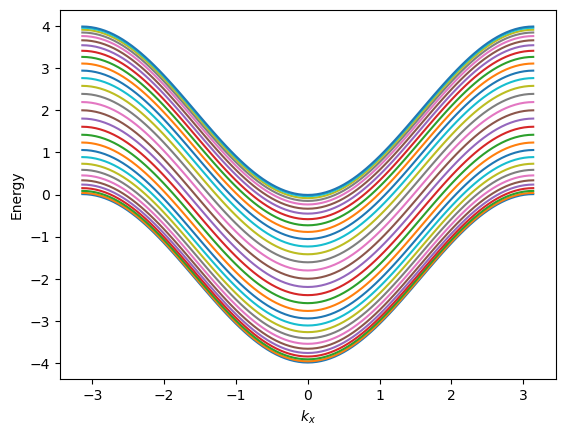

In [52]:
bands = kwant.physics.Bands(fsyst.leads[0])
momenta = np.linspace(-np.pi, np.pi, 101)
energies = [bands(k) for k in momenta]
plt.plot(momenta, energies)
plt.ylabel('Energy')
plt.xlabel('$k_x$')
plt.show()


# Si sólo queremos el plot, una opción todavía más sencilla es usar esta función de kwant.plotter
# kwant.plotter.bands(fsyst.leads[0], show = False);

# 4. Resolvemos el problema de scattering: 

El principal resultado de Kwant es la solución del problema de scattering calculando la propagación desde los leads de los modos de ondas planas a una energía $E$. 
Dicho de otro modo, dado un set de modos a energía E en el lead 0, obtenemos la probabilidad de que cada uno de esos  estados se propaguen hasta cada uno de los modos del lead 1. 
Esquemáticamente: 


<img src="./1_figures/continuum_right.png" alt="Drawing" style="width: 400px;"/>

Obtenemos así la matriz de scattering $S$,
\begin{equation}
S = \left(
\begin{matrix} r & t \\ t' & r' \end{matrix}
\right)
\end{equation}

Como veremos en la teoría, esta probabilidad se relaciona con la corriente (la conductancia) por la fórmula de Landauer-Buttiker, que se puede escribir como: 

\begin{equation}
I = \frac{e}{\hbar} \int \frac{dk}{2\pi}
[ v_k [ 1 - |r|^2 ] f_L[E(k)] - v_k |t'|^2  f_R[E(k)] ]
\end{equation}
with
\begin{equation}
f_L(E)= \frac{1}{e^{(E-\mu_L)/kT_L} + 1}
f_R(E)= \frac{1}{e^{(E-\mu_R)/kT_R} + 1}
\end{equation}
In 1D, the velocity $dE/dk$ is the inverse of the density of state $dk/dE$, so that,
\begin{equation}
I = \frac{e}{h} \int dE  |t|^2  [f_L[E(k)] - f_R[E(k)] ]
\end{equation}
which at zero temperature and small bias $\mu_L = E_F + eV/2$,
$\mu_R = E_F - eV/2$ simplifies into the
celebrated Landauer formula,
\begin{equation}
I = \frac{e^2}{h} |t(E_F)|^2  V
\end{equation}

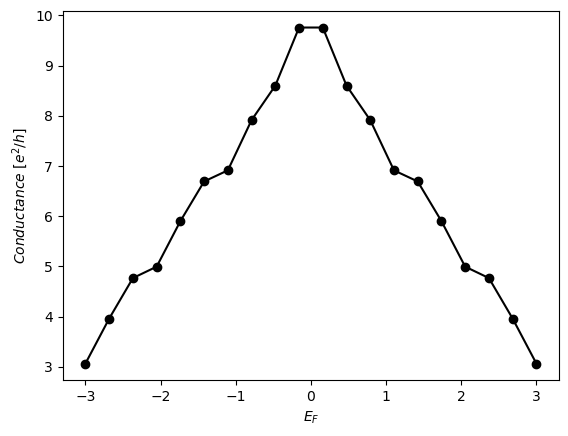

In [53]:
## Calculamos la conductancia para E = -3 hasta E = 3. 

Es = np.linspace(-3, 3, 20)
gs = []
for E in Es:
    S = kwant.solvers.default.smatrix(sys = fsyst, energy = E)
    ## Este solver se abrevia como: 
    # S = kwant.smatrix(sys = fsyst, energy = E)
    gs.append(S.transmission(1, 0))
plt.plot(Es, gs, 'ok-')
plt.ylabel("$Conductance ~[e^2/h]$")
plt.xlabel("$E_F $");

Hemos visto ejemplos de todos los módulos principales excepto kwant.operators. 

    [x] kwant.builder – Construcción de sistemas
    [x] kwant.lattice – Redes de Bravais
    ----------------------    
    [x] kwant.plotter – Representación gráfica de sistemas
    [x] kwant.physics – Algoritmos relacionados con la física
    ----------------------
    [x] kwant.solvers – Biblioteca de solucionadores
    kwant.operator – Operadores y observables
    

# 5. Visualizamos algunos observables

Uno de los puntos interesantes de kwant es la posibilidad de visualizar observables con depenencia espacial de forma sencilla

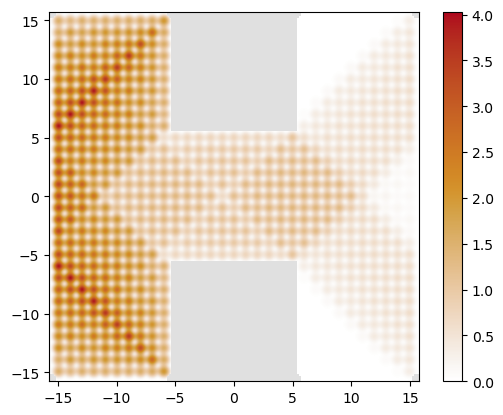

In [55]:
lead_in = 0
psi = kwant.wave_function(fsyst, energy=0)(lead_in)
rho = kwant.operator.Density(fsyst)

kwant.plotter.density(fsyst, 
                  np.sum([rho(psi[i]) for i in range(len(psi))], axis = 0));

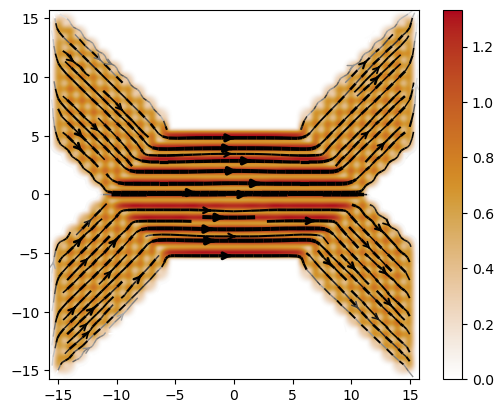

In [58]:
J = kwant.operator.Current(fsyst)
kwant.plotter.current(fsyst, 
                  np.sum([J(psi[i]) for i in range(len(psi))], axis = 0));

* The particle current density associated with a  wave function reads,
\begin{equation}
I(x) = i\frac{\hbar}{2m} \left[\Psi (x)^* \frac{\partial}{\partial x} \Psi (x) -
\Psi (x) \frac{\partial}{\partial x} \Psi^* (x)\right]
\end{equation}
or in its discrete form,
\begin{equation}
I_n = i\frac{1}{\hbar} [\Psi_{n}^* \Psi_{n+1} - \Psi_{n+1}^* \Psi_{n}]
\end{equation}
For a plane wave,
\begin{equation}
\Psi_{n} = e^{ikn}
\end{equation}
we get
\begin{equation}
I_n = i \frac{1}{\hbar}[e^{ik} - e^{-ik}] = \frac{1}{\hbar} v_k
\end{equation}
\begin{equation}
v_k \equiv \frac{\partial}{\partial k} E(k)
\end{equation}

* For a scattering state,
\begin{equation}
\Psi_{n} = e^{ikn} + r e^{-ikn}
\end{equation}
\begin{equation}
I_n = v_k [ 1 - |r|^2 ]
\end{equation}

* Current conservation implies that $1 - |r|^2 = |t|^2 = |t'|^2 = 1 - |r'|^2$
and more generally that the S matrix is unitary,
\begin{equation}
S S^\dagger = 1
\end{equation}





1. Solve Schrödinger equation in the leads *first* (using Bloch's theorem)
2. Match the solution in the scattering region

# Solving the Schrodinger equation in the leads

$$
\begin{pmatrix}
   \ddots &                   &     &       & \\
V_l & H_l & V_l^\dagger \\
    & V_l               & H_l & V_l^\dagger \\
    &                   & V_l               & H_l & V_l^\dagger \\
    &                   &     &       & \ddots \\
\end{pmatrix}
\begin{pmatrix}
⋮ \\ ψ_{-1} \\ ψ_0 \\ ψ_1 \\ ⋮ 
\end{pmatrix}
=
E
\begin{pmatrix}
⋮ \\ ψ_{-1} \\ ψ_0 \\ ψ_1 \\ ⋮ 
\end{pmatrix}
$$

Use Bloch's theorem: $ψ_n = λ^n φ$

$$
\begin{pmatrix}
   \ddots &                   &     &       & \\
V_l & H_l & V_l^\dagger \\
    & V_l               & H_l & V_l^\dagger \\
    &                   & V_l               & H_l & V_l^\dagger \\
    &                   &     &       & \ddots \\
\end{pmatrix}
\begin{pmatrix}
⋮ \\ λ^{-1}φ \\ φ \\ λφ \\ ⋮ 
\end{pmatrix}
=
E
\begin{pmatrix}
⋮ \\ λ^{-1}φ \\ φ \\ λφ \\ ⋮ 
\end{pmatrix}
$$

Each row reduces to the following:

$$
V_l φ + λ(H_l - E)φ + λ^2V_l^\daggerφ = 0
$$

A finite problem that we can solve!

*Given* $E$, what are the corresponding $φ$'s and $λ$'s?

**Quadratic eigenvalue problem in λ: what do?**

write: $ξ \equiv λφ$, then

<br/>

$$
\begin{pmatrix}
H_l - E & V_l^\dagger \\ 1 & 0
\end{pmatrix}
\begin{pmatrix}
φ \\ ξ
\end{pmatrix}
=
λ^{-1}
\begin{pmatrix}
-V_l & 0 \\ 0 & 1
\end{pmatrix}
\begin{pmatrix}
φ \\ ξ
\end{pmatrix}
$$

<br/>

→ Generalized Eigenvalue Problem.

<br/>

Hard to do in stable way; sorting it all out is **the hardest part of Kwant**

<br/>

(If you're feeling brave check out `kwant/physics/leads.py:compute_block_modes` in the Kwant source coode)

*propagating* modes: $|λ| = 1$ ; *evanescent* modes: $|λ| \ne 1$

*mode velocity*: $v = iφ^\dagger[λV_l^\dagger - λ^{-1}V_l]φ$

$φ$'s then *normalized* to have unit velocity (current)

Arbitrary state in unit cell $n$:

$$\hat{φ}_n = ΦΛ^nq$$

$$\begin{align}
Φ: &\text{matrix of mode wavefunctions ($φ$'s)} \\
Λ: &\text{diagonal matrix of eigenvalues} \\
q: &\text{column vector of mode amplitudes} \\
\end{align}$$

# Solving the leads with Kwant

## First, the lead dispersion relation

topo_params = dict(A=0.09, B=-0.18, D=-0.065, M=-0.02, mu=0)  # Parameters for topological phase
trivial_params = dict(A=0.09, B=-0.18, D=-0.065, M=0.01, mu=0)  # Parameters for trivial phase

kwant.plotter.bands(fsyst.leads[0], params=topo_params,);
plt.hlines(0, -np.pi, np.pi, linestyles='--');

## 2- Obtener la conductancia a través de la matriz de scattering

In [ ]:
energies = np.linspace(0, 1) #definimos un barrrido de energías de 0 a 1
data = []
for energy in energies:
    # compute the scattering matrix at a given energy
    smatrix = kwant.smatrix(syst, energy)
    # compute the transmission probability from lead 0 to lead 1
    data.append(smatrix.transmission(1, 0))

In [ ]:
# Por último pintamos la conductancia vs energía
fig, ax = plt.subplots(1)
ax.plot(energies, data);
ax.grid(which='major', axis='y');
ax.set_xlabel('Energy [t]');
ax.set_ylabel('Conductance G [$2 e^2/\hbar$]');
plt.show();

## ¡Tu turno!
### ¿Qué pasa si cambiamos el tamaño del sistema?

Ideas principiantes:
- Copia el código y modifica L, W1, W2.
- La conductancia cambia con L?
- ¿Qué pasa si aumentamos W1? ¿El caso W1=W2? ¿Si W1>W2?

Ideas avanzadas:
- Puedes definir una función make_syst(L, W1, W2) que te facilite el cambio de parámetros. Explora cómo se modifica la conductancia cambiando L, W1 y W2
- Puedes cambiar la forma modificando la función shapeConstr(). ¿Qué efecto tiene un borde más suave?

## Soluciones:
En estas soluciones definimos una función que nos cree el sistema para un determinado L, W1, W2 y nos devuelva la conductancia. De este modo agilizamos el proceso de comparación

In [ ]:
def obtain_conductance(energies, syst):
    data = []
    for energy in energies:
        # compute the scattering matrix at a given energy
        smatrix = kwant.smatrix(syst, energy)
        # compute the transmission probability from lead 0 to lead 1
        data.append(smatrix.transmission(1, 0))
    return data
def make_syst(L, W1, W2):
    t = 1; a = 1;

    syst = kwant.Builder() #inicializamos el Builder
    lat = kwant.lattice.square(a) # en este caso usaremos una red cuadrada de parámetro 1

    def shapeConstr(pos): # Definimos la forma del QPC
        x, y, = pos
        if abs(x)<= L/2:
            return abs(y)<=W1/2
        elif L/2 <= x <= L or -L <= x <= -L/2:
            return abs(y)<=W2/2

    syst[lat.shape(shapeConstr, (0, 0))]=4*t # rellenamos el sistema

    syst[lat.neighbors()] = -t # creamos la conexión con los vecinos

    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0))) #creamos el lead en -x

    def shape_lead(pos):
        x, y = pos
        return abs(y)<=W2/2

    lead[lat.shape(shape_lead, (-L,0))] = 4 * t
    lead[lat.neighbors()] = -t

    lead_r = lead.reversed() #usamos la función reversed para crear un lead en la dirección +x

    syst.attach_lead(lead); #pegamos los leads al sistema
    syst.attach_lead(lead_r);

    syst = syst.finalized()
    return syst

def make_syst_getCond(L, W1, W2, enegies):
    syst = make_syst(L, W1, W2)
    cond = obtain_conductance(energies, syst)
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
    kwant.plot(syst, ax=ax1)
    ax2.plot(energies, cond);
    ax2.grid(which='major', axis='y');
    ax2.set_xlabel('Energy [t]');
    ax2.set_ylabel('Conductance G [$e^2/\hbar$]');
    plt.show();
    return cond

In [ ]:
## La conductancia no depende de L
energies = np.linspace(0,1)

condL10 = make_syst_getCond(L=10, W1=10, W2=20, enegies=energies)
condL50 = make_syst_getCond(L=50, W1=10, W2=20, enegies=energies)


In [ ]:
## La conductancia se modifica con W1
#(cambia el número de canales y para W1=W2 los escalones quedan perfectamente bien definidos)
energies = np.linspace(0,0.5, 150)

condW1_10 = make_syst_getCond(L=10, W1=10, W2=40, enegies=energies)
condW1_25 = make_syst_getCond(L=10, W1=25, W2=40, enegies=energies)
condW1_40 = make_syst_getCond(L=10, W1=40, W2=40, enegies=energies)

# para W1>W2 se desdibuja la cuantización de la conductancia
condW1_60 = make_syst_getCond(L=10, W1=60, W2=40, enegies=energies)



In [ ]:
## Por último, una forma más suave suaviza los escalones

energies = np.linspace(0,1)
L, W1, W2 = 10, 10, 30

t = 1; a = 1;

syst = kwant.Builder() #inicializamos el Builder
lat = kwant.lattice.square(a) # en este caso usaremos una red cuadrada de parámetro 1

def shapeConstr(pos): # Definimos la forma del QPC
    x, y, = pos
    if abs(x)<= L/2:
        return abs(y)<=W1/2+x**2/4
    elif L/2 <= x <= L or -L <= x <= -L/2:
        return abs(y)<=W2/2

syst[lat.shape(shapeConstr, (0, 0))]=4*t # rellenamos el sistema

syst[lat.neighbors()] = -t # creamos la conexión con los vecinos

lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0))) #creamos el lead en -x

def shape_lead(pos):
    x, y = pos
    return abs(y)<=W2/2

lead[lat.shape(shape_lead, (-L,0))] = 4 * t
lead[lat.neighbors()] = -t

lead_r = lead.reversed() #usamos la función reversed para crear un lead en la dirección +x

syst.attach_lead(lead); #pegamos los leads al sistema
syst.attach_lead(lead_r);

syst = syst.finalized()

## obtain conductance and plot
cond = obtain_conductance(energies, syst)
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
kwant.plot(syst, ax=ax1)
ax2.plot(energies, cond);
ax2.grid(which='major', axis='y');
ax2.set_xlabel('Energy [t]');
ax2.set_ylabel('Conductance G [$e^2/\hbar$]');
plt.show();
